# Trabajo Práctico: Exploración y Preparación de Airbnb Listings


## Objetivo
En esta libreta analizamos el dataset `listings_big.csv` para comprender su estructura, diagnosticar problemas de calidad y preparar un conjunto de features apto para estimar **qué tan alquilable es un listing**. El flujo general incluye:
- Exploración inicial y resumen estadístico
- Análisis de valores faltantes y patrones de disponibilidad
- Visualizaciones que permitan interpretar la ocupación y sus drivers
- Definición de un problema supervisado de clasificación enfocado en la alta ocupación
- Construcción de un pipeline de preprocesamiento, ingeniería de variables y selección/reducción de dimensionalidad


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (8, 5)
pd.set_option('display.max_columns', 80)

DATA_PATH = Path('listings_big.csv')


## 1. Carga y saneamiento inicial


In [21]:
df_raw = pd.read_csv(DATA_PATH)
df = df_raw.copy()
# Limpieza de precios: eliminar símbolos y convertir a numérico
df['price'] = (df['price']
               .astype(str)
               .str.replace(r'[€$£,]', '', regex=True)
               .str.strip())
df['price'] = pd.to_numeric(df['price'], errors='coerce')
# Conversión de columnas fecha para posteriores features
date_columns = ['last_scraped', 'host_since', 'first_review', 'last_review']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')
# Normalización de flags binarias
def to_bool(series):
    mapped = series.map({'t': 'yes', 'f': 'no'})
    return mapped.astype('object')
for col in ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'has_availability']:
    if col in df.columns:
        df[col] = to_bool(df[col])
print(f"Shape original: {df_raw.shape}")
print(f"Shape después de transformaciones básicas: {df.shape}")


Shape original: (35172, 79)
Shape después de transformaciones básicas: (35172, 79)


### 1.1 Información general del dataset


In [22]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35172 entries, 0 to 35171
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            35172 non-null  int64         
 1   listing_url                                   35172 non-null  object        
 2   scrape_id                                     35172 non-null  int64         
 3   last_scraped                                  35172 non-null  datetime64[ns]
 4   source                                        35172 non-null  object        
 5   name                                          35172 non-null  object        
 6   description                                   34299 non-null  object        
 7   neighborhood_overview                         16588 non-null  object        
 8   picture_url                                   35171 non-null  obje

In [23]:
# Resumen de tipos de columnas y conteo por tipo
type_summary = df.dtypes.value_counts().rename('count').to_frame()
type_summary


,count
object,30
int64,24
float64,21
datetime64[ns],4


In [24]:
# Estadísticas descriptivas de variables numéricas
numeric_summary = df.select_dtypes(include=[np.number]).describe().T
numeric_summary


,count,mean,std,min,25%,50%,75%,max
id,35172.0,7.117880e+17,4.840974e+17,1.150800e+04,4.719776e+07,8.875662e+17,1.095206e+18,1.344330e+18
scrape_id,35172.0,2.025013e+13,0.000000e+00,2.025013e+13,2.025013e+13,2.025013e+13,2.025013e+13,2.025013e+13
host_id,35172.0,2.143294e+08,2.027420e+08,1.342600e+04,3.070016e+07,1.421004e+08,4.298024e+08,6.754917e+08
host_listings_count,35166.0,1.953964e+01,4.128934e+01,1.000000e+00,1.000000e+00,3.000000e+00,1.600000e+01,6.700000e+02
host_total_listings_count,35166.0,2.942555e+01,7.958366e+01,1.000000e+00,1.000000e+00,4.000000e+00,2.000000e+01,2.542000e+03
neighbourhood_group_cleansed,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,35172.0,-3.459155e+01,1.825693e-02,-3.469370e+01,-3.460267e+01,-3.459089e+01,-3.458105e+01,-3.453498e+01
longitude,35172.0,-5.841729e+01,3.016859e-02,-5.853089e+01,-5.843705e+01,-5.841891e+01,-5.839211e+01,-5.835540e+01
accommodates,35172.0,2.943535e+00,1.550894e+00,1.000000e+00,2.000000e+00,2.000000e+00,4.000000e+00,1.600000e+01
bathrooms,31602.0,1.236504e+00,6.569959e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.200000e+01


In [25]:
# Estadísticas básicas de variables categóricas/cadenas
categorical_cols = df.select_dtypes(include=['object', 'string']).columns
categorical_summary = df[categorical_cols].describe().T
categorical_summary.head(20)


,count,unique,top,freq
listing_url,35172,35172,https://www.airbnb.com/rooms/11508,1
source,35172,2,city scrape,31613
name,35172,32871,Departamento en Buenos Aires,98
description,34299,30441,Enjoy the simplicity of this quiet and central...,148
neighborhood_overview,16588,13465,"San Telmo, a historic neighborhood in Buenos A...",64
picture_url,35171,34512,https://a0.muscache.com/pictures/hosting/Hosti...,9
host_url,35172,17820,https://www.airbnb.com/users/show/11256892,222
host_name,35166,4344,Federico,533
host_location,27619,742,"Buenos Aires, Argentina",22667
host_about,18881,7371,Amamos al mundo y nos encanta viajar en él!\nB...,222


### 1.2 Exploración de duplicados y consistencia


In [26]:
duplicate_count = df.duplicated(subset=['id']).sum()
print(f"Duplicados basados en 'id': {duplicate_count}")

missing_ids = df['id'].isna().sum()
print(f"IDs faltantes: {missing_ids}")


Duplicados basados en 'id': 0
IDs faltantes: 0


## 2. Valores faltantes


In [27]:
missing_abs = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_abs / len(df)).round(4)
missing_table = pd.DataFrame({'missing': missing_abs, 'percent': missing_pct})
missing_table.head(20)


,missing,percent
neighbourhood_group_cleansed,35172,1.0000
calendar_updated,35172,1.0000
license,34782,0.9889
neighbourhood,18584,0.5284
neighborhood_overview,18584,0.5284
host_about,16291,0.4632
host_neighbourhood,13451,0.3824
host_location,7553,0.2147
review_scores_value,5761,0.1638
review_scores_accuracy,5761,0.1638


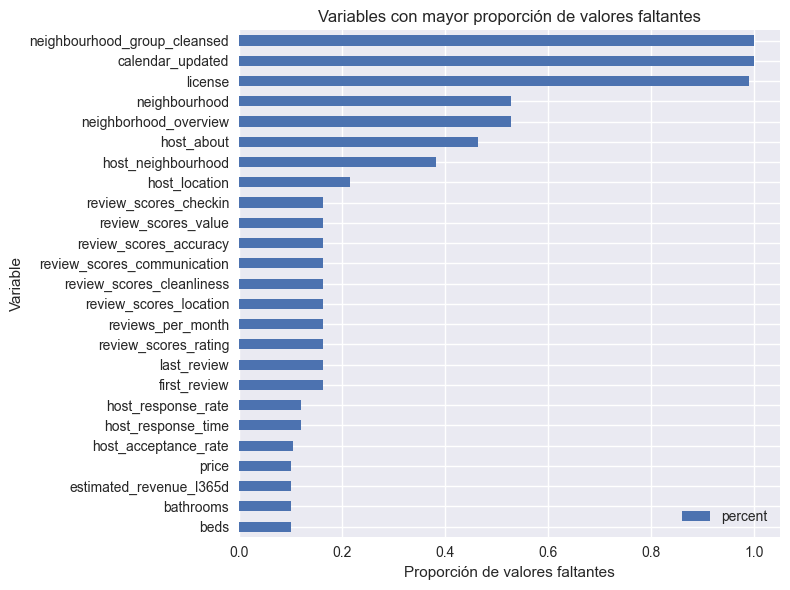

In [28]:
# Visualización del top de variables con mayor porcentaje de faltantes
top_missing = missing_table[missing_table['percent'] > 0].head(25)
ax = top_missing.sort_values('percent').plot.barh(y='percent', figsize=(8, 6))
ax.set_xlabel('Proporción de valores faltantes')
ax.set_ylabel('Variable')
ax.set_title('Variables con mayor proporción de valores faltantes')
plt.tight_layout()
plt.show()


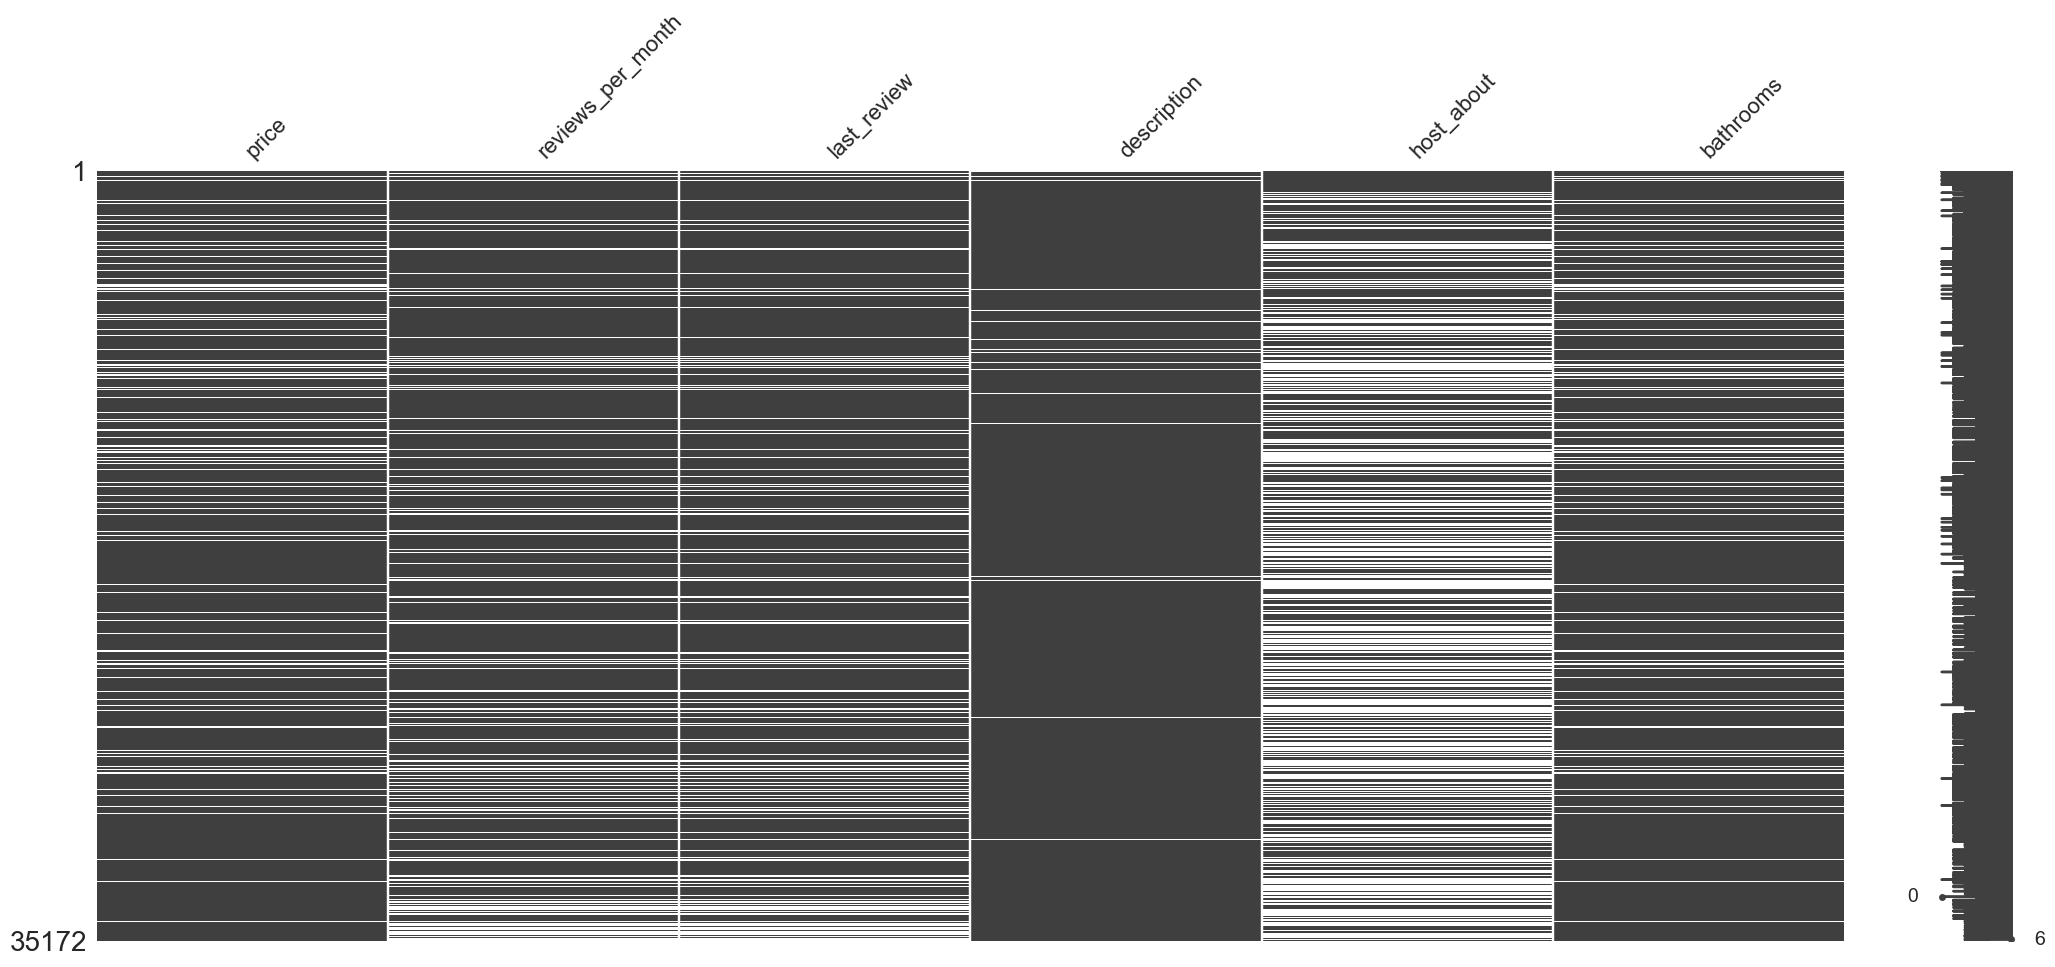

In [29]:
# Matriz de missingness para detectar patrones
try:
    import missingno as msno
    msno.matrix(df[['price', 'reviews_per_month', 'last_review', 'description', 'host_about', 'bathrooms']])
    plt.show()
except ImportError:
    print('missingno no está disponible en el entorno actual.')


In [30]:
# Ejemplo de análisis MAR/MNAR: comparar reviews_per_month faltante vs número de reviews
reviews_missing_flag = df['reviews_per_month'].isna()
comparison = df.groupby(reviews_missing_flag)['number_of_reviews'].agg(['mean', 'median', 'count'])
comparison.index = ['reviews_per_month disponible', 'reviews_per_month faltante']
comparison


,mean,median,count
reviews_per_month disponible,33.516456,17.0,29412
reviews_per_month faltante,0.000000,0.0,5760


**Interpretación inicial:** La ausencia de `reviews_per_month` suele darse en listados sin reseñas recientes, sugiriendo un mecanismo MAR (dependiente de `number_of_reviews`).


## 3. Distribuciones y visualizaciones clave


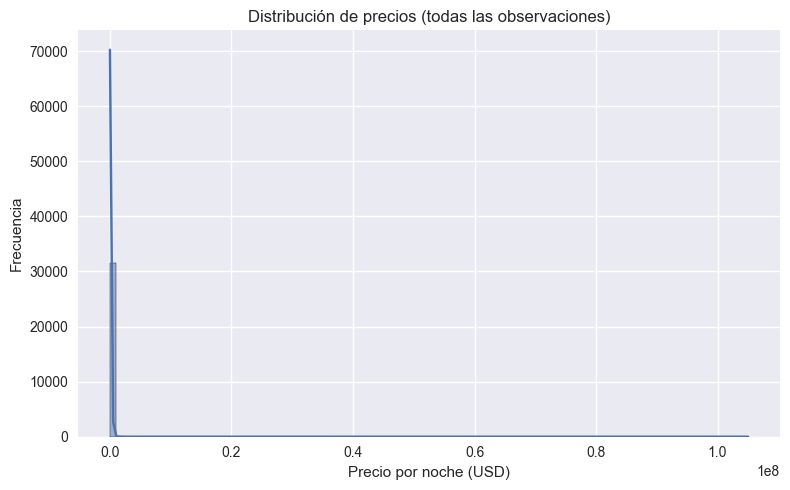

In [31]:
sns.histplot(df['price'].dropna(), bins=100, kde=True)
plt.title('Distribución de precios (todas las observaciones)')
plt.xlabel('Precio por noche (USD)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


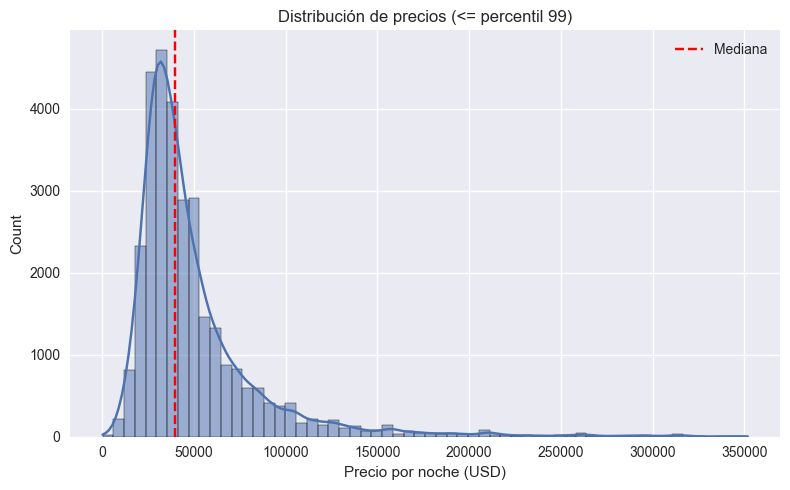

In [32]:
# Distribución recortando el 1% superior para atenuar outliers
price_cap = df['price'].quantile(0.99)
sns.histplot(df.loc[df['price'] <= price_cap, 'price'], bins=60, kde=True)
plt.axvline(df['price'].median(), color='red', linestyle='--', label='Mediana')
plt.title('Distribución de precios (<= percentil 99)')
plt.xlabel('Precio por noche (USD)')
plt.legend()
plt.tight_layout()
plt.show()


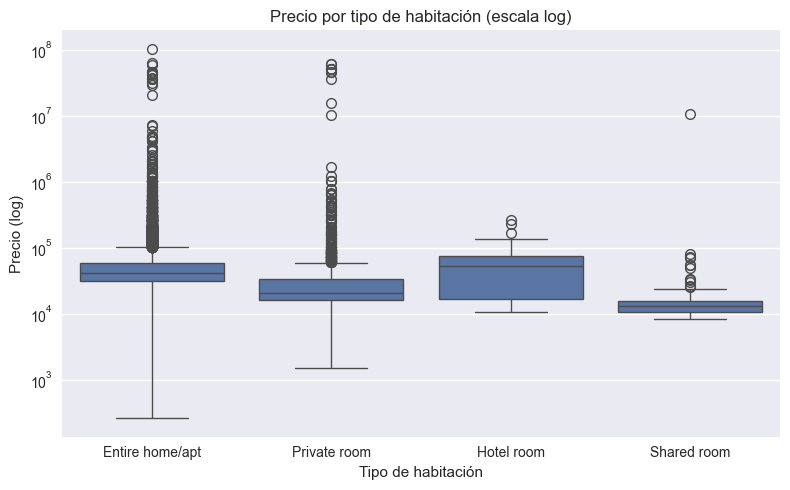

In [33]:
sns.boxplot(data=df, x='room_type', y='price')
plt.yscale('log')
plt.title('Precio por tipo de habitación (escala log)')
plt.xlabel('Tipo de habitación')
plt.ylabel('Precio (log)')
plt.tight_layout()
plt.show()


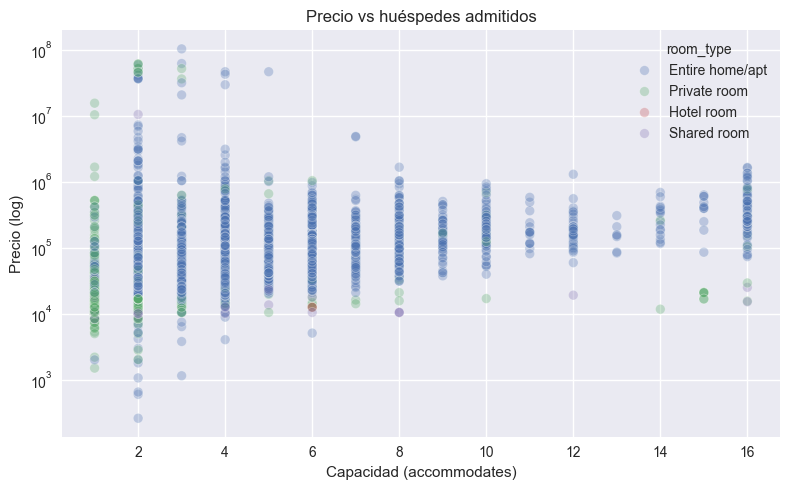

In [34]:
# Precio vs capacidad
sns.scatterplot(data=df, x='accommodates', y='price', hue='room_type', alpha=0.3)
plt.yscale('log')
plt.title('Precio vs huéspedes admitidos')
plt.xlabel('Capacidad (accommodates)')
plt.ylabel('Precio (log)')
plt.tight_layout()
plt.show()


### Distribuciones de disponibilidad y ocupación


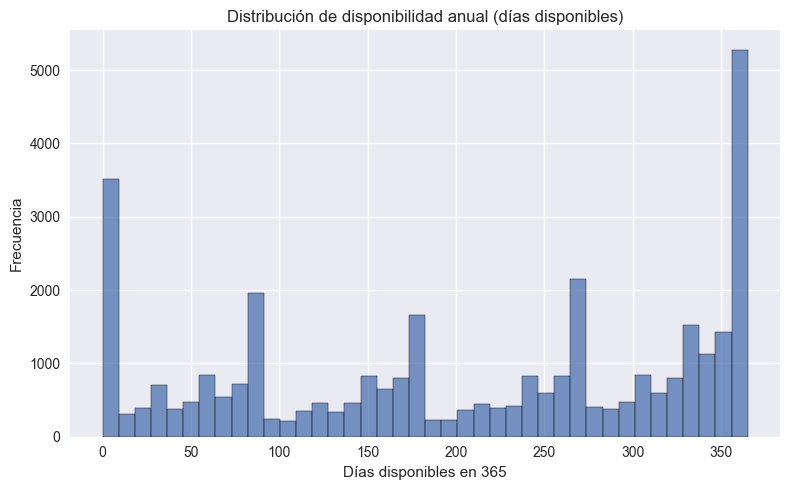

In [35]:
sns.histplot(df['availability_365'], bins=40, kde=False)
plt.title('Distribución de disponibilidad anual (días disponibles)')
plt.xlabel('Días disponibles en 365')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


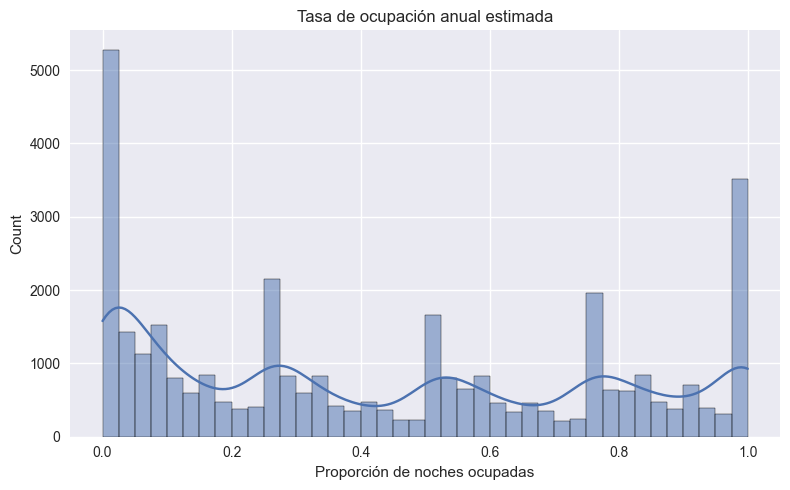

In [36]:
sns.histplot(1 - (df['availability_365'] / 365), bins=40, kde=True)
plt.title('Tasa de ocupación anual estimada')
plt.xlabel('Proporción de noches ocupadas')
plt.tight_layout()
plt.show()


### Correlación orientada a disponibilidad (categóricas codificadas)
Para estudiar los drivers de disponibilidad aplicamos one-hot encoding sobre las variables categóricas y analizamos la correlación con las tasas de ocupación.


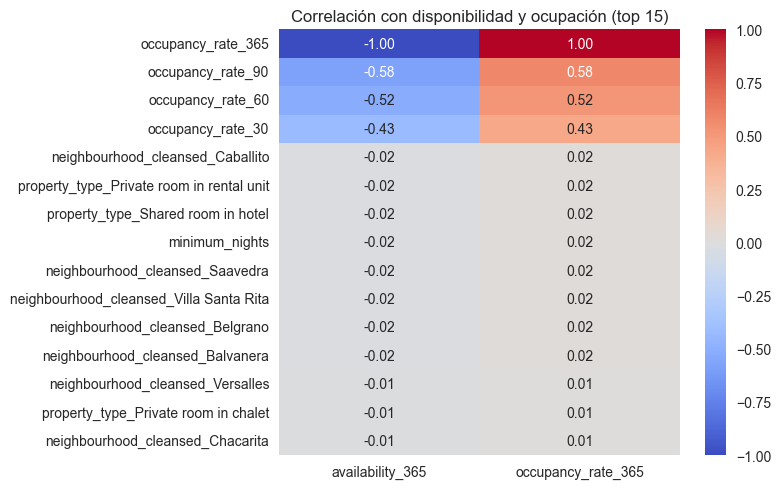

,availability_365,occupancy_rate_365
occupancy_rate_365,-1.000000,1.000000
occupancy_rate_90,-0.582185,0.582185
occupancy_rate_60,-0.520114,0.520114
occupancy_rate_30,-0.425884,0.425884
neighbourhood_cleansed_Caballito,-0.021693,0.021693
property_type_Private room in rental unit,-0.019277,0.019277
property_type_Shared room in hotel,-0.018689,0.018689
minimum_nights,-0.018640,0.018640
neighbourhood_cleansed_Saavedra,-0.017703,0.017703
neighbourhood_cleansed_Villa Santa Rita,-0.017377,0.017377


In [37]:
# Codificación de categóricas para matriz de correlación orientada a disponibilidad
availability_cols = ['availability_30', 'availability_60', 'availability_90', 'availability_365']
base_columns = ['accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
                'number_of_reviews', 'reviews_per_month', 'price']

corr_base = df[base_columns + availability_cols].copy()

for horizon in [30, 60, 90, 365]:
    rate_col = f'occupancy_rate_{horizon}'
    if rate_col not in df.columns:
        df[rate_col] = 1 - (df[f'availability_{horizon}'] / horizon)
    corr_base[rate_col] = df[rate_col]

binary_map = {'yes': 1, 'no': 0}
for col in ['host_is_superhost', 'instant_bookable']:
    corr_base[f'{col}_flag'] = df[col].map(binary_map)

categorical_for_corr = ['room_type', 'property_type', 'neighbourhood_cleansed']
corr_encoded = pd.get_dummies(
    pd.concat([corr_base, df[categorical_for_corr]], axis=1),
    columns=categorical_for_corr,
    drop_first=True
)

corr_matrix = corr_encoded.corr(numeric_only=True)
target_corr = corr_matrix[['availability_365', 'occupancy_rate_365']].sort_values(
    by='occupancy_rate_365', ascending=False
)

top_features = target_corr.head(15).index
sns.heatmap(
    corr_matrix.loc[top_features, ['availability_365', 'occupancy_rate_365']],
    annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1
)
plt.title('Correlación con disponibilidad y ocupación (top 15)')
plt.tight_layout()
plt.show()

target_corr.head(15)


## 4. Disponibilidad y objetivo de ocupación


In [38]:
# Cálculo de tasas de ocupación a partir de la disponibilidad
availability_cols = ['availability_30', 'availability_60', 'availability_90', 'availability_365']
occupancy_df = df[availability_cols].copy()

for horizon in [30, 60, 90, 365]:
    rate_col = f'occupancy_rate_{horizon}'
    df[rate_col] = 1 - (df[f'availability_{horizon}'] / horizon)
    occupancy_df[rate_col] = df[rate_col]

occupancy_summary = occupancy_df[[f'occupancy_rate_{h}' for h in [30, 60, 90, 365]]].describe().T
print(occupancy_summary[['mean', 'std', 'min', '25%', '50%', '75%', 'max']])

# Target multiclase basado en la tasa anual
bins = [0.0, 0.4, 0.7, 1.01]
labels = ['low', 'mid', 'high']
df['occupancy_level'] = pd.cut(
    df['occupancy_rate_365'].clip(lower=0, upper=1),
    bins=bins, labels=labels, right=False, include_lowest=True
)

level_counts = df['occupancy_level'].value_counts(dropna=False).sort_index()
print('Distribución de occupancy_level:')
print(level_counts)
print('Proporciones:')
print((level_counts / len(df)).round(3))


                        mean       std  min       25%       50%       75%  max
occupancy_rate_30   0.509806  0.400941  0.0  0.066667  0.500000  1.000000  1.0
occupancy_rate_60   0.445735  0.379611  0.0  0.050000  0.383333  0.833333  1.0
occupancy_rate_90   0.393470  0.366022  0.0  0.044444  0.300000  0.688889  1.0
occupancy_rate_365  0.433947  0.345724  0.0  0.087671  0.367123  0.758904  1.0
Distribución de occupancy_level:
occupancy_level
low     18047
mid      6834
high    10291
Name: count, dtype: int64
Proporciones:
occupancy_level
low     0.513
mid     0.194
high    0.293
Name: count, dtype: float64


**Decisión:** Se utilizará la etiqueta multiclase `occupancy_level` para representar la ocupación esperada (low/mid/high). El objetivo del modelado es predecir este nivel sin emplear variables de disponibilidad futuras.


## 5. Planteo del problema supervisado
Planteamos un problema de **clasificación multiclase** donde la variable target es `occupancy_level`, construida a partir de la tasa de ocupación anual estimada. Los niveles son:
- `high`: ocupación >= 70%
- `mid`: ocupación entre 40% y 70%
- `low`: ocupación < 40%

El objetivo es anticipar la categoría de ocupación utilizando únicamente atributos conocidos al momento de publicar un listing (sin recurrir a disponibilidades futuras). Se evaluará con métricas como F1 macro, balanced accuracy y matrices de confusión para garantizar buen desempeño en las tres clases.

Las features consideradas combinan atributos de ubicación (`latitude`, `longitude`, `neighbourhood_cleansed`), configuración (`room_type`, `property_type`, `accommodates`, `bedrooms`), reputación (`number_of_reviews`, `reviews_per_month`, `host_is_superhost`) y métricas derivadas de la actividad del host (`host_tenure_days`, `reviews_per_year`, `days_since_last_review`).


**Definición del target:** `occupancy_level` surge de discretizar la tasa de ocupación anual en tres bandas (`low`, `mid`, `high`) con umbrales (0.0, 0.4, 0.7, 1.0]. Esto permite capturar distintos perfiles de demanda y evita depender de la disponibilidad futura como feature. Registros sin información suficiente quedan con valor nulo y se descartan durante el split de entrenamiento.


## 6. Ingeniería de features y preprocesamiento


In [39]:
# Feature engineering orientado a ocupación
# Imputar reseñas por mes faltantes con 0 (sugiere ausencia de reseñas)
df['reviews_per_month_filled'] = df['reviews_per_month'].fillna(0)

# Antigüedad del host y tiempo desde la última reseña
reference_date = df['last_scraped'].max()
df['host_tenure_days'] = (reference_date - df['host_since']).dt.days

df['days_since_last_review'] = (reference_date - df['last_review']).dt.days

# Densidad de reseñas: reviews acumulados sobre tenure (evitar división por cero)
df['reviews_per_year'] = df['number_of_reviews'] / (df['host_tenure_days'] / 365)
df.loc[df['host_tenure_days'] <= 0, 'reviews_per_year'] = np.nan

# Construimos dataset sin columnas de disponibilidad para evitar fuga de información
feature_cols = [
    'accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
    'number_of_reviews', 'reviews_per_month_filled', 'latitude', 'longitude',
    'host_is_superhost', 'instant_bookable', 'room_type', 'property_type',
    'neighbourhood_cleansed', 'host_tenure_days', 'days_since_last_review', 'reviews_per_year'
]

model_df = df[feature_cols + ['occupancy_level']].copy()
model_df.head()


,accommodates,bedrooms,beds,minimum_nights,maximum_nights,number_of_reviews,reviews_per_month_filled,latitude,longitude,host_is_superhost,instant_bookable,room_type,property_type,neighbourhood_cleansed,host_tenure_days,days_since_last_review,reviews_per_year,occupancy_level
0,2,1.0,1.0,3,1125,44,0.29,-34.581840,-58.424150,yes,no,Entire home/apt,Entire condo,Palermo,5603.0,7.0,2.866322,low
1,2,1.0,1.0,7,40,123,0.80,-34.586170,-58.410360,no,no,Entire home/apt,Entire rental unit,Palermo,3105.0,15.0,14.458937,high
2,1,NaN,NaN,29,730,0,0.00,-34.538920,-58.465990,no,no,Private room,Private room in rental unit,Nuñez,5541.0,NaN,0.000000,high
3,4,1.0,1.0,2,1125,45,0.27,-34.614390,-58.376110,yes,yes,Entire home/apt,Entire loft,Monserrat,5522.0,1891.0,2.974466,low
4,4,2.0,2.0,2,365,330,1.84,-34.581848,-58.441605,NaN,no,Entire home/apt,Entire rental unit,Palermo,5481.0,16.0,21.975917,mid


In [40]:
target_col = 'occupancy_level'
X = model_df.drop(columns=[target_col])
y = model_df[target_col]

print(f'Observaciones totales para modelado: {len(X)}')
print(f'Registros sin target: {y.isna().sum()} (serán descartados antes del split)')


Observaciones totales para modelado: 35172
Registros sin target: 0 (serán descartados antes del split)


In [41]:
from sklearn.model_selection import train_test_split

valid_rows = y.notna()
X_valid = X.loc[valid_rows]
y_valid = y.loc[valid_rows]

X_train, X_test, y_train, y_test = train_test_split(
    X_valid, y_valid, test_size=0.2, random_state=42
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")


Train: (28137, 17), Test: (7035, 17)


In [42]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_features = [
    'accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
    'number_of_reviews', 'reviews_per_month_filled', 'latitude', 'longitude',
    'host_tenure_days', 'days_since_last_review', 'reviews_per_year'
]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = [
    'host_is_superhost', 'instant_bookable', 'room_type', 'property_type', 'neighbourhood_cleansed'
]

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

print(f'Matriz transformada - train: {X_train_prepared.shape}')
print(f'Matriz transformada - test: {X_test_prepared.shape}')


Matriz transformada - train: (28137, 130)
Matriz transformada - test: (7035, 130)


### Balance del target (low/mid/high)


In [43]:
y_train.value_counts(normalize=True).sort_index()


occupancy_level
low     0.513097
mid     0.194228
high    0.292675
Name: proportion, dtype: float64

## 7. Selección y reducción de dimensionalidad


In [44]:
# Importancia de features numéricas (ANOVA F-score)
from sklearn.feature_selection import f_classif

numeric_matrix = preprocessor.named_transformers_['num'].transform(X_train[numeric_features])
f_scores, p_values = f_classif(numeric_matrix, y_train)

anova_scores = (pd.Series(f_scores, index=numeric_features)
                  .sort_values(ascending=False))
anova_scores


days_since_last_review      307.136854
beds                        163.251001
reviews_per_month_filled    118.928763
accommodates                 60.952019
number_of_reviews            59.643118
maximum_nights               54.874881
reviews_per_year             22.823178
bedrooms                     11.118423
minimum_nights               10.443251
longitude                     6.111885
host_tenure_days              2.804617
latitude                      1.734308
dtype: float64

In [45]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

numeric_matrix = preprocessor.named_transformers_['num'].transform(X_train[numeric_features])
selector = SelectKBest(score_func=mutual_info_classif, k=min(8, len(numeric_features)))
selector.fit(numeric_matrix, y_train)

selected_numeric = [numeric_features[i] for i in selector.get_support(indices=True)]
print('Mejores features numéricas según mutual information:', selected_numeric)


Mejores features numéricas según mutual information: ['beds', 'minimum_nights', 'maximum_nights', 'latitude', 'longitude', 'host_tenure_days', 'days_since_last_review', 'reviews_per_year']


In [46]:
from sklearn.decomposition import PCA

# Aplicamos PCA sobre features numéricas estandarizadas
numeric_imputed = preprocessor.named_transformers_['num'].fit_transform(X_train[numeric_features])
pca = PCA().fit(numeric_imputed)
explained_variance = pd.DataFrame({
    'componente': np.arange(1, len(pca.explained_variance_ratio_) + 1),
    'var_ratio': pca.explained_variance_ratio_,
    'var_acumulada': np.cumsum(pca.explained_variance_ratio_)
})
explained_variance.head(10)


,componente,var_ratio,var_acumulada
0,1,0.197514,0.197514
1,2,0.185981,0.383495
2,3,0.129124,0.512619
3,4,0.102804,0.615424
4,5,0.083484,0.698908
5,6,0.078941,0.777849
6,7,0.071169,0.849018
7,8,0.040751,0.889769
8,9,0.036747,0.926516
9,10,0.033494,0.960009


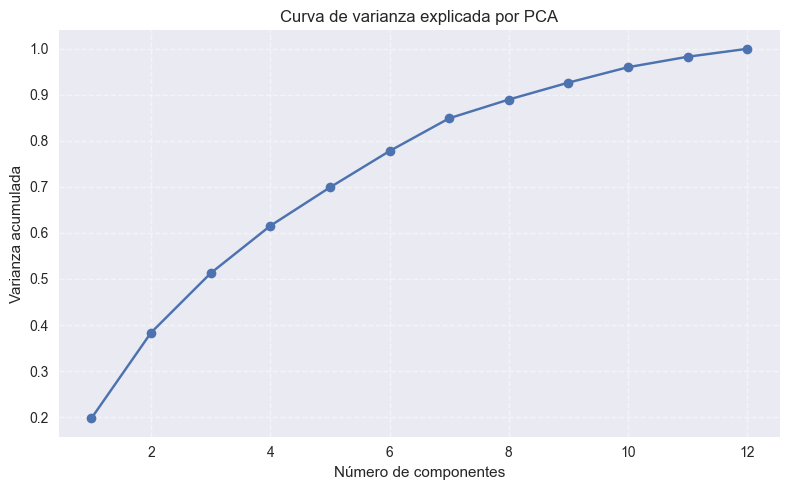

In [47]:
plt.plot(explained_variance['componente'], explained_variance['var_acumulada'], marker='o')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.title('Curva de varianza explicada por PCA')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**Interpretación:** Con ~6 componentes se retiene alrededor del 80% de la varianza numérica, útil si se necesita compactar el espacio antes de entrenar clasificadores sensibles a la dimensionalidad (p. ej. regresión logística).


## 8. Próximos pasos sugeridos
- Entrenar clasificadores multiclase (`LogisticRegression`, `RandomForestClassifier`, `XGBoost`) usando el pipeline de `preprocessor`.
- Medir F1 macro, balanced accuracy y analizar la matriz de confusión para los niveles `low/mid/high`.
- Ajustar umbrales o reglas de decisión según la estrategia comercial (p. ej. priorizar recall de `high`).
- Incorporar nuevas variables disponibles al crear el anuncio (amenities, políticas, texto) para mejorar el poder predictivo sin depender de disponibilidad futura.


- Entrenar un modelo base (p. ej. `RandomForestRegressor`, `GradientBoostingRegressor`) usando el pipeline de `preprocessor`.
- Validar con una métrica robusta (MAE) y comparar contra un baseline como la mediana.
- Explorar ingeniería específica del vecindario (densidad de listings, precio medio por zona) y disponibilidad.
- Evaluar estrategias de tuning (GridSearch/Optuna) y monitoreo de drift con `wandb`.
